## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm

# import matplotlib for plotting graphs
import matplotlib.pyplot as plt

# 'magic word' so that visualizations are plotted inline with the notebook
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/Users/Lauren/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Load data and print out a few lines

# Read csv into pandas dataframe and store as df
df = pd.read_csv('ab_data.csv')

# View the first five lines of the dataframe
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# Gives no. of rows, columns as a tuple
df.shape

(294478, 5)

There are 294,478 rows in the dataset.

c. The number of unique users in the dataset.

In [4]:
# Number of unique users
df.nunique()['user_id']

290584

There are 290,584 unique users in the dataset.

d. The proportion of users converted.

In [5]:
# Proportion of users converted
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Number of times new_page and treatment don't line up
error_new_page = df.query("landing_page == 'new_page' and group != 'treatment'").count()[0]
error_treatment = df.query("group == 'treatment' and landing_page != 'new_page'").count()[0]

print(error_new_page + error_treatment)

3893


In [7]:
# Understanding the A/B Test data
count_control_old = df.query("landing_page == 'old_page' and group == 'control'").count()[0]
count_control_new = df.query("landing_page == 'new_page' and group == 'control'").count()[0]
count_treatment_old = df.query("landing_page == 'old_page' and group == 'treatment'").count()[0]
count_treatment_new = df.query("landing_page == 'new_page' and group == 'treatment'").count()[0]

print("Control (Old)")
print(count_control_old)

print("Control (New)")
print(count_control_new)

print("Treatment (Old)")
print(count_treatment_old)

print("Treatment (New)")
print(count_treatment_new)

Control (Old)
145274
Control (New)
1928
Treatment (Old)
1965
Treatment (New)
145311


f. Do any of the rows have missing values?

In [8]:
# Print information about the dataframe to see if any rows contain null data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


We can see from the above that none of the rows in the columns contain missing data.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

Remove the rows where where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page** so that we are confident in the accuracy of the data.

In [9]:
# Create a new dataframe where the rows described above are removed
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
# Number of unique users in df2
df2.nunique()['user_id']

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# Check that there is only one duplicate user_id in df2
df2.user_id.duplicated().sum()

1

In [13]:
# Row where user_id is repeated
df2.loc[df2.duplicated('user_id') == True]['user_id']

2893    773192
Name: user_id, dtype: int64

Here we see that user_id **773192** is repeated.

c. What is the row information for the repeat **user_id**? 

In [14]:
# Row where user_id is repeated
duplicate_row = df2.loc[df2.duplicated('user_id') == True]
duplicate_row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# Drop duplicate row
df2.drop(df2.index[2893], inplace=True)

df2.head()

/Users/Lauren/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [16]:
# Check that one row has been removed
df2.shape[0]

290584

Here we have 290584 rows which is the same as the number of unique rows above thus we have dropped one duplicate row.

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# Probability of an individual converting regardless of the page they receive
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# Probability of individual converting that is in control group
p_control = df2.query("group == 'control'")['converted'].mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# Probability of individual converting that is in treatment group
p_treatment = df2.query("group == 'treatment'")['converted'].mean()
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
# Probability that an individual received the page
df2.query("landing_page == 'new_page'").count()[0] / len(df2)

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**From the above, there is not suffficient evidence to say that the new page leads to more conversions as the conversion rate for the treatment group (0.1188) is actually slightly lower than the conversion rate from the control group (0.1204).**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} \leq p_{old} $$


$$H_1: p_{new} > p_{old}$$

where,

$p_{old}$ and $p_{new}$ are the converted rates for the old and new pages, respectively.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

Under this null, our hypotheses become:

$$ H_0: p_{new} = p_{old} $$


$$ H_1: p_{new} \neq p_{old} $$

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
# Sample size for new_page 
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [24]:
# Sample size for old_page 
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
# Use NumPys binomial to simulate n_new transactions with a convert rate of p_new under the null
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17542

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
# Use NumPys binomial to simulate n_old transactions with a convert rate of p_old under the null
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17489

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
p_new_sim = new_page_converted / n_new
p_old_sim = old_page_converted / n_old
p_new_sim - p_old_sim

0.00033491220864347027

This value is close to zero.

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []

for _ in range(10000):
    # Simulate conversion rate for old page and new page
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    # Calculate the difference of conversion rates
    diff = new_page_converted / n_new - old_page_converted / n_old
    # Append differences
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

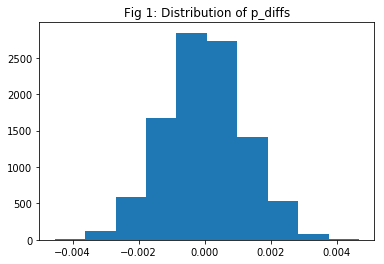

In [29]:
plt.hist(p_diffs)
plt.title('Fig 1: Distribution of p_diffs');

The histogram is normally distributed, as expected.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# Observed difference
p_diffs_obs = p_treatment - p_control
p_diffs_obs

-0.0015782389853555567

From the above calculation for the observed difference, the control group conversion rate is greater than that of the treatment group. Thus, the old page seems to be performing better than the new page.

In [31]:
# Proportion of p_diffs that are greater than p_diffs_obs
count = 0
for p in p_diffs:
    if p > p_diffs_obs:
        count = count + 1
        
proportion = count / len(p_diffs)
proportion

0.9041

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

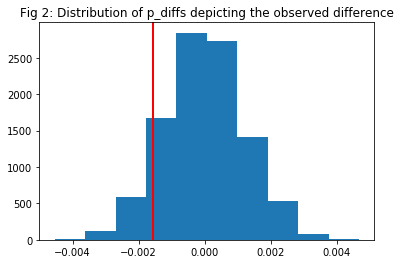

In [32]:
# Plot p_diffs as well as the observed difference (red line)
plt.hist(p_diffs)
plt.axvline(x=p_diffs_obs, color = 'r', linewidth=2)
plt.title('Fig 2: Distribution of p_diffs depicting the observed difference');

**This is the p-value, in other words the probability of observing our statistic or something more extreme if the null hypothesis is true. Remember the null hypothesis was that the conversion rate for the old page and the new page are equal.**

Plotted above (Fig 2) is p_diffs for the null hypothesis and the red line is our statistic - the actual observed difference (p_diffs_obs). Everything to the right of the red line/ observed difference is the proportion of p_diffs that are greater than the observed difference, we calculated this proportion to be **0.90**.  

From this analysis we see that our p-value of 0.90 is very large and greater than our Type 1 Error threshold of 5%. Therefor, we fail to reject the null in favour of the alternative (which suggested that the new page conversion rate was higher than that of the old page). 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
# Number of trials or individuals that received each page is calculated above in n_old & n_new
n_old = n_old
n_new = n_new

# Number of successes/ conversions for each page
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]

print(convert_old)
print(convert_new)

17489
17264


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
# larger means: prop > value (observed value), this is also justified by the graph above
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


Here we use a 95% confidence interval because $1 - CI = \alpha$, where CI is the confidence interval.

Thus, $CI = 1- \alpha$ = $1 - 0.05 = 0.95$

In [35]:
from scipy.stats import norm

# Tells us what our critical value at 95% confidence is
critical_val = norm.ppf(1-(0.05/2))
critical_val

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- The p-value calculated using the 'proportions_ztest' built-in function (0.905) is very similar to the p-value calculated using the null hypothesis above (0.904). Again, from the high p-value we fail to reject the null in favour of the alternative. 


- For a right-tailed Z-test, the null is rejected if the one-sided z-value is greater than or equal to the critical value. Since the z-score value of -1.31 is less than the critical value of 1.96, we fail to reject the null.

This agrees with the findings in part __k__.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** (I called this column **treatment**) column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
# Create a column for intercept
df2['intercept'] = 1

# Replace group column with the dummy version
# if you do not put the explanatory variables in alphabetical
# order your answers will be wrong!!
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])

# remove control column so that you have a full rank matrix
df2 = df2.drop('control', axis=1)

df2.head()

/Users/Lauren/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Lauren/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
# Used this resource: https://github.com/statsmodels/statsmodels/issues/3931
# to fix error thrown for the issue with the missing function chisqprob
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'treatment']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Jan 2018   Pseudo R-squ.:               8.077e-06
Time:                        00:56:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **treatment**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with treatment is: **0.190**. This p-value is different from the p-values calculated in **Part II**. This is because this is a two-sided test and the tests in **Part II** were a one-sided test (the p-value was the proportion greater than the observed difference - see Fig 2)

In regression, the alternative hypothesis was to test that the new page and old page were not equal to one another, this being a two-sided test could mean that the new page is better or worse than the old page:

$$ H_0: p_{new} = p_{old} $$


$$ H_1: p_{new} \neq p_{old} $$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


It is a good idea to take other factors into account in your regression model beacause of the effects of Simpson's Paradox. An example of Simpson's paradox could be that the predictor variables that you are using to measure the response do not give an accurate depiction of the model (there may be more than one variable that affects the response and perhaps you leave one or more than one of these variables out), thus the hypothesis results may be unreliable.

Disadvantages of adding additional terms into your regression model are examples of multicollinearity, another could be that your model does not converge due to adding too many data points. Multicollinearity is when our predictor variables are correlated with one another, this leads to the innacurate relationships between your x-variables and the response as well as the hypothesis test results being unreliable. One way to see if our predictor variables are correlated is by using Variance Inflation Factors (VIF). 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
# Read csv into pandas dataframe and store as countries_df
countries_df = pd.read_csv('./countries.csv')

# Merge df2 and countries_df and make user_id the index (as they match on index)
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,treatment
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [40]:
# What countries are in the country column?
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [41]:
# Create a column for intercept
df_new['intercept'] = 1

# Replace group column with the dummy version
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

# remove CA column so that you have a full rank matrix (CA is our baseline)
df_new = df_new.drop('CA', axis=1)

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,treatment,UK,US
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,1


In [42]:
# Fit Model
log_mod_new = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results_new = log_mod_new.fit()

results_new.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Jan 2018   Pseudo R-squ.:               1.521e-05
Time:                        00:56:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

Does it appear that country had an impact on conversion?

From the results above, if a p-value is less than 0.05, this suggests there is a statistically significant relationship between the variable and the response. None of the p-values for the countries appear to be less than 0.05, suggesting that country does not have an impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
# Fit Your Linear Model And Obtain the Results
log_mod_int = sm.Logit(df_new['converted'], df_new[['intercept', 'treatment', 'UK', 'US']])
results_int = log_mod_int.fit()

results_int.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Jan 2018   Pseudo R-squ.:               2.323e-05
Time:                        00:56:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Niether the country nor the page seems to have a significant impact on conversion from the analysis above as the p-values are greater than 0.05. 

<a id='conclusions'></a>
## Conclusions

For **Part I - Probability**, our conclusion was that there was not suffficient evidence to say that the new page leads to more conversions as the conversion rate for the treatment group (0.1188) was actually slightly lower than the conversion rate from the control group (0.1204).

In **Part II - A/B Test**, we performed a sampling distribution for the difference in **conversions** between the two pages over 10,000 iterations, under the null. From this analysis we found that the p-value to be very large (0.904) and therefor, we failed to reject the null in favour of the alternative. We also used a built-in approach to achieve similar results (p-value = 0.905) and using the results from the z-test and p-test, again, our conclusion was that we failed to reject the null.

In **Part III - A regression approach**, we used logistic regression to model the A/B test. The p-value was found to be 0.190, this was very different to the p-values for the above two sections. In regression we use two-sided tests instead of a one sided test as done in the previous two sections above. The alternative hypothesis was to test that the new page and old page were not equal to one another, this being a two-sided test could mean that the new page is better or worse than the old page. We also looked at whether the country or the page had an impact on conversion and from the results they did not seem to have an impact on conversion. 

Although the results seems to suggest that the new page does not perform better than the old page, there may be bias results due to change aversion. My recommendation would be to run the experiment longer and to perform this anlysis once more data has been gathered over a longer period of time.

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.

 ### References
 
 - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.nunique.html
 - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html
 - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html
 - https://stackoverflow.com/questions/39802076/pandas-drop-row-based-on-index-vs-ix
 - https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.binomial.html
 - https://github.com/statsmodels/statsmodels/issues/3931
 - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.unique.html
 - http://knowledgetack.com/python/statsmodels/proportions_ztest/
 - http://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html
 - https://onlinecourses.science.psu.edu/stat500/node/44
